<a href="https://colab.research.google.com/github/waizwafiq/BBR-ContinAuth/blob/main/train_BBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as pproc
import seaborn as sns

In [156]:
#from google.colab import files
#uploaded = files.upload()

In [157]:
df = pd.read_csv('test.csv')

In [158]:
#IRRELEVANT FEATURES TO REMOVE
del df['t']
del df['ttc']
del df['paused_time']
#del df['x']
#del df['y']
del df['s_euclid_c']
del df['pauses']
df['genuine'] = 1
df.head(4)

,paused_time_ratio,x,dx,y,dy,ds,theta,c,c_roc,v_x,v_y,v,a,j,w,straightness,jitter,genuine
0,0.0,182,0,51,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,1
1,0.0,182,0,48,-3,3.000000,1.570796,0.523599,0.174533,0.000000,-279.462315,279.462315,26033.061743,2.425087e+06,146.326126,1.000000,0.000000,1
2,0.0,181,-1,48,0,1.000000,-0.000000,-1.570796,-2.094395,-66.036677,0.000000,66.036677,-14093.919854,-2.649853e+06,-103.730169,0.790569,1.333333,1
3,0.0,180,-1,47,-1,1.414214,0.785398,0.555360,1.503420,-64.679706,-64.679706,91.470918,1645.079220,1.017994e+06,50.799322,0.825999,1.353553,1


In [159]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
print(X)
print(y)
print(X.shape[1],"features")

     paused_time_ratio    x  dx  ...           w  straightness    jitter
0             0.000000  182   0  ...    0.000000      1.000000  0.000000
1             0.000000  182   0  ...  146.326126      1.000000  0.000000
2             0.000000  181  -1  ... -103.730169      0.790569  1.333333
3             0.000000  180  -1  ...   50.799322      0.825999  1.353553
4             0.000000  180   0  ...   50.521891      0.839567  1.184699
..                 ...  ...  ..  ...         ...           ...       ...
521           0.590694  429 -21  ...    5.623450      0.075521  1.003402
522           0.590173  416 -13  ...   -1.696152      0.075234  1.002125
523           0.589687  409  -7  ...    1.816273      0.075074  1.001128
524           0.589183  405  -4  ...   -3.735580      0.075028  1.000661
525           0.588684  404  -1  ...   29.748461      0.074952  1.000148

[526 rows x 17 columns]
0      1
1      1
2      1
3      1
4      1
      ..
521    1
522    1
523    1
524    1
525    1


## **DATA SCALING AND PCA**

In [160]:
scaler = pproc.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled)

In [161]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.96)
principalComponents = pca.fit_transform(X_scaled)
X_PCA = pd.DataFrame(principalComponents) #data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PCA4'])
X_PCA.head(3)

,0,1,2,3,4,5,6,7,8
0,-0.558249,0.548173,-0.072907,-0.090136,0.548397,-0.512511,-0.038109,-0.005020,0.049682
1,-0.522494,0.535019,-0.359642,0.435301,0.565401,-0.484752,0.056566,0.003494,0.111063
2,-0.560323,0.348571,0.054944,-0.273264,0.467975,-0.316511,-0.596671,-0.025073,-0.073937


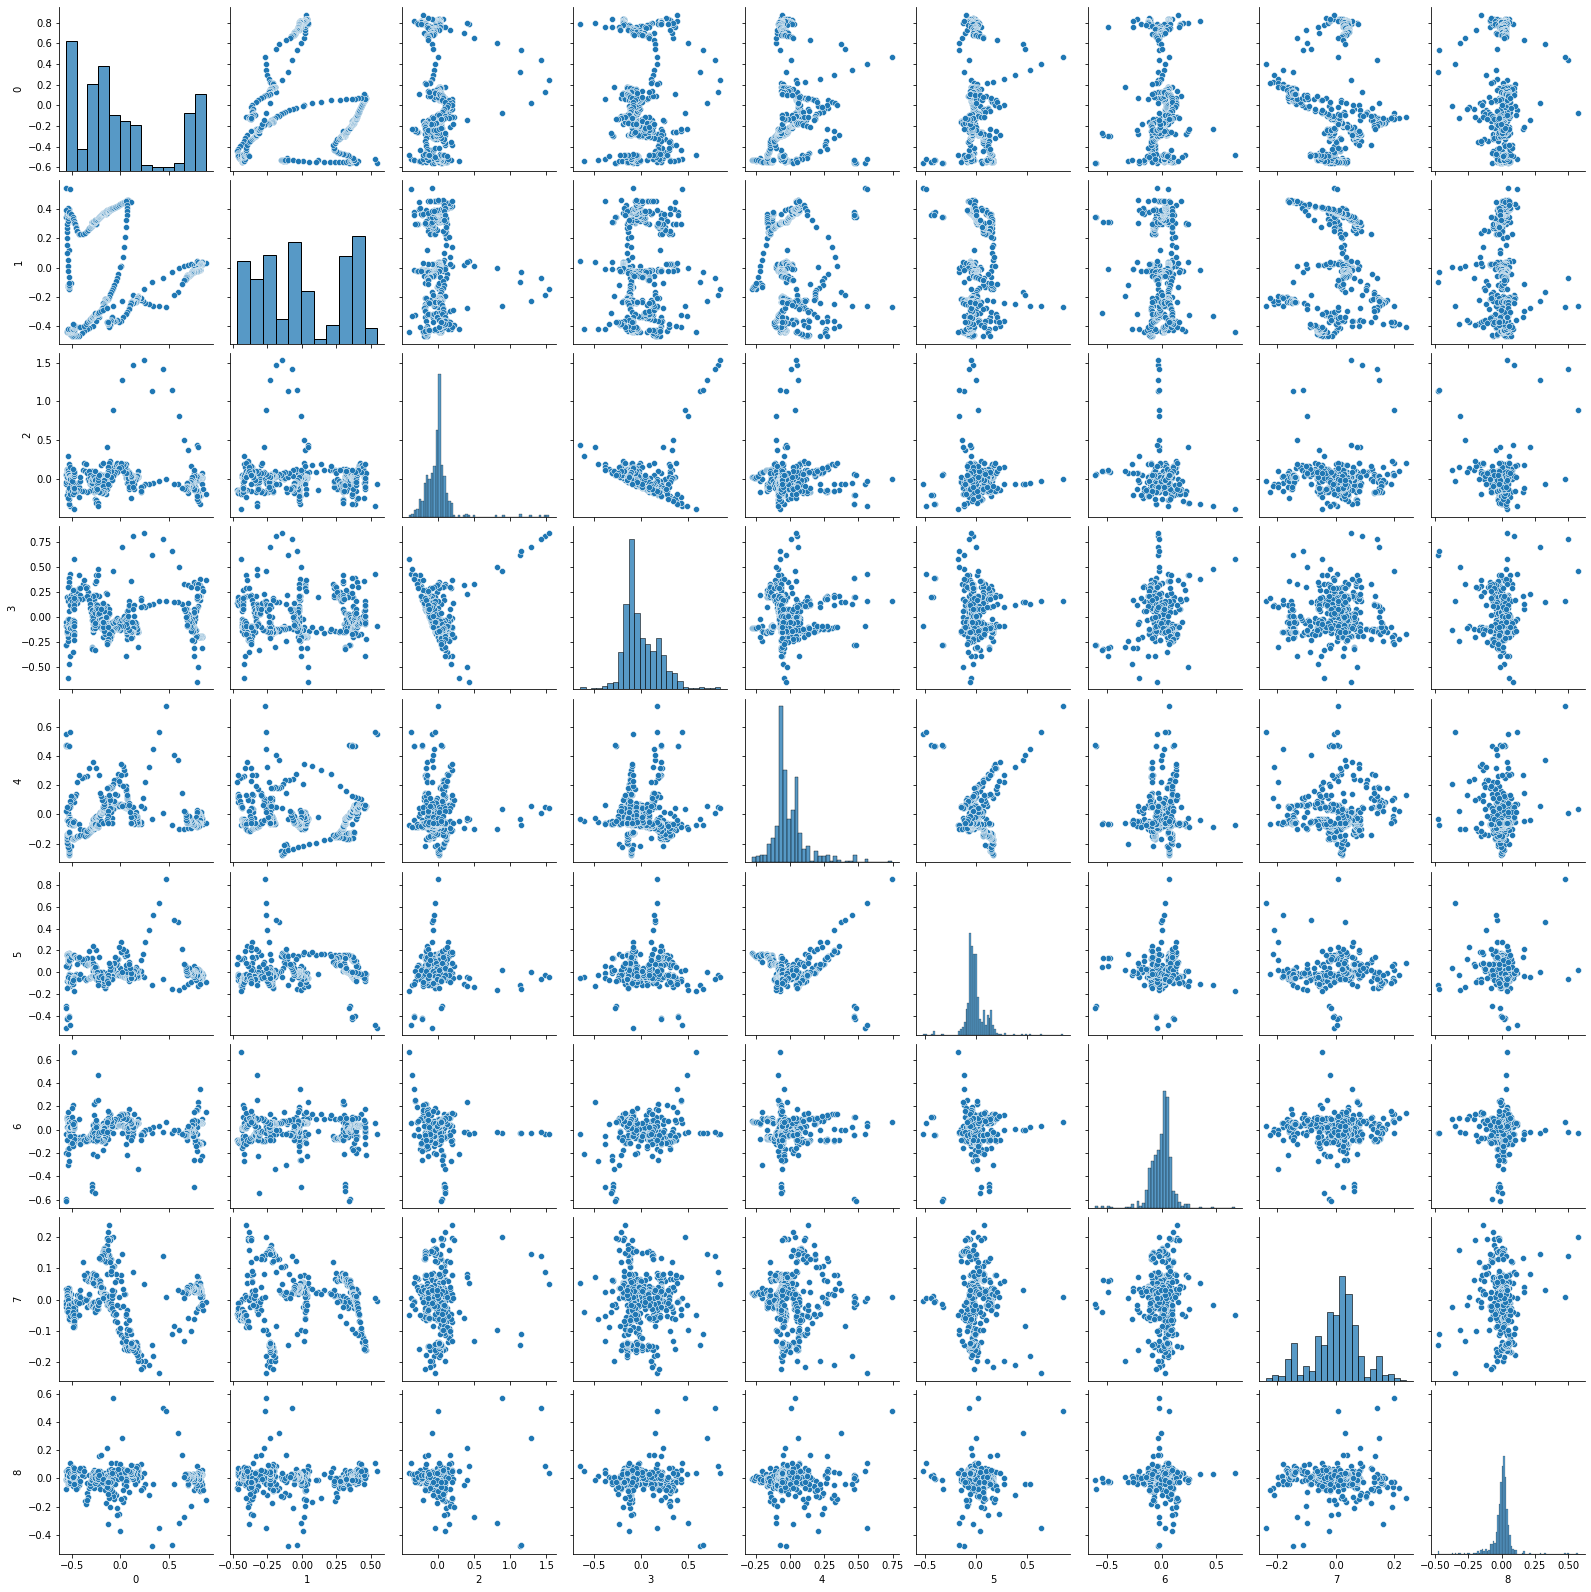

In [162]:
sns.pairplot(X_PCA)

In [163]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_PCA , y, shuffle = True, test_size=0.3, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(X_PCA.shape)

(368, 9)
(158, 9)
(526, 9)


## **ONE-CLASS CLASSIFICATION MODEL BUILDING**

In [164]:
from sklearn.svm import OneClassSVM
from numpy import quantile, where, random
import matplotlib.pyplot as plt

In [165]:
x_axis = 2
y_axis = 1

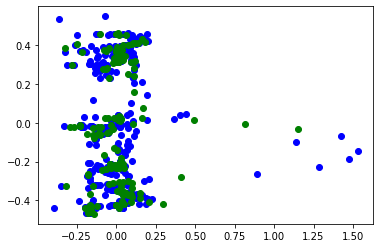

In [166]:
plt.scatter(X_train.values[:,x_axis], X_train.values[:,y_axis], color='b')
plt.scatter(X_test.values[:,x_axis], X_test.values[:,y_axis], color='g')
plt.show()

In [167]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.01)

training time

In [168]:
'''pred = svm.fit_predict(X_train)
scores = svm.score_samples(X_train)
'''
svm.fit(X_train)
pred = svm.predict(X_train)

In [170]:
'''thresh = quantile(scores, 0.03)
print(thresh)
'''
anom_index_train = where(pred==-1)
values = X_train.values[anom_index_train]

In [171]:
index = where(scores <= thresh)
values = X_train.values[index] #get the data (anomalies) where scores <= thresh 

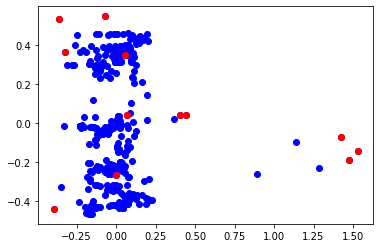

In [172]:
plt.scatter(X_train.values[:,x_axis], X_train.values[:,y_axis], color='b')
plt.scatter(values[:,x_axis], values[:,y_axis], color='r')
plt.show()

testing time

In [173]:
pred_test = svm.predict(X_test)
scores_test = svm.score_samples(X_test)
thresh_test = quantile(scores, 0.03)
thresh_test

3.669300273358377

In [174]:
'''index = where(scores_test <= thresh_test)
values_test = X_test.values[index]
'''
anom_index_test = where(pred_test==-1)
values_test = X_test.values[anom_index_test]

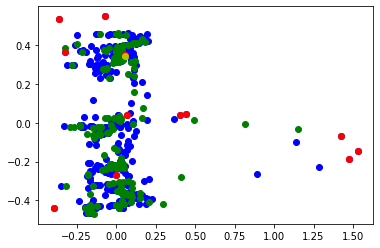

In [175]:
plt.scatter(X_train.values[:,x_axis], X_train.values[:,y_axis], color='b')
plt.scatter(X_test.values[:,x_axis], X_test.values[:,y_axis], color='g')
plt.scatter(values[:,x_axis], values[:,y_axis], color='r')
plt.scatter(values_test[:,x_axis], values_test[:,y_axis], color='y')
plt.show()

In [176]:
print("during testing:",len(values_test)*len(values_test[0]), "anomalies of", len(X_test.values))

during testing: 9 anomalies of 158


In [177]:
print("True probability = ",1-(len(values_test)+len(values)) / len(X_PCA))

True probability =  0.9752851711026616


**DOWNLOAD MODEL**

In [178]:
import pickle

pkl_filename = "user1_ocSVM.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svm, file)